In [12]:
import os
import json
import pandas as pd
from collections import defaultdict

# Aggregations

In [14]:
def read(path,filename,metric):
    result=[]
    with open(path,'r') as f:
        dict_ = {}
        for line in f:
            token, score = line.split('\t')
            field = "_".join([filename,metric])
            new_dict[token][field]=float(score[:-1])
            dict_[token]=float(score[:-1])
        dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda item: item[1], reverse=True)}
        result = [{'task':filename, 'metric':metric, 'token':k, 'score':v, 'rank':i} for i, (k,v) in enumerate(dict_.items())]
        
    return result

results=[]
metrics = ['cosine','distance','jsd']
for metric in metrics:
    for filename in os.listdir(f"results/{metric}"):
        if filename!='discovery_noun' and filename!='discovery_verb': 
            print(filename)
            path = os.path.join(f"results/{metric}", filename)
            results += read(path, filename,metric)

        
        


average.txt
bert_base
error_detect
gold.txt
histbert
histbert-10
histbert-5
histbert-full
ling_accept
majority_vote_ave.txt
majority_vote_max.txt
majority_vote_min.txt
max.txt
min.txt
ner
nli
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
sst2
sst2_local_finetune
sst_hously
sst_pfeiffer
textual_sim
average.txt
bert_base
error_detect
gold.txt
histbert
histbert-10
histbert-5
histbert-full
ling_accept
majority_vote_ave.txt
majority_vote_max.txt
majority_vote_min.txt
max.txt
min.txt
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
average.txt
bert_base
error_detect
gold.txt
histbert
histbert-10
histbert-5
histbert-full
ling_accept
majority_vote_ave.txt
majority_vote_max.txt
majority_vote_min.txt
max.txt
min.txt
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim


In [52]:
with open('all_results.json','w') as f:
    json.dump(results,f)

In [53]:
results[0]

{'task': 'average.txt',
 'metric': 'cosine',
 'token': 'plane',
 'score': 1.1606159062596062,
 'rank': 0}

In [71]:
from collections import Counter
df = pd.DataFrame(results)
df['score'] = df['score'].astype(float)

37
{'prop': 22, 'ounce': 6, 'face': 32, 'head': 29, 'bit': 15, 'chairman': 1, 'gas': 18, 'savage': 28, 'player': 2, 'record': 2, 'bag': 19, 'word': 34, 'part': 23, 'tip': 5, 'tree': 24, 'circle': 31, 'contemplation': 35, 'land': 19, 'plane': 0, 'donkey': 36, 'fiction': 11, 'rag': 8, 'attack': 17, 'stroke': 15, 'stab': 6, 'edge': 26, 'ball': 14, 'risk': 12, 'relationship': 18, 'multitude': 34, 'twist': 22, 'lass': 30, 'lane': 5, 'pin': 4, 'quilt': 7, 'graft': 5, 'thump': 27}


In [82]:
def majority_vote(token_list,token_rank, df, metric, method):
    df_metric = df[df['metric']==metric]
    token_list = set(df_metric['token'].tolist())
    print(len(token_list))
    token_rank = {token: Counter(df_metric[df_metric['token']==token]['rank'].tolist()).most_common()[0][0] for token in token_list}
    print(token_rank)
    
    with open(f"results/{metric}/majority_vote_{method}.txt","w") as f:
        for token in token_list:
           
            target = df_metric[(df_metric['token']==token)&(df_metric['rank']==token_rank[token])]['score'].tolist()
          
            if method=='ave':
                score = sum(target)/len(target)
            elif method=='max':
                score = max(target)
            elif method=='min':
                score = min(target)
            f.write((token+'\t'+str(score)+'\n'))
        


In [91]:
majority_vote(token_list,token_rank, df, 'jsd', 'min')

37
{'prop': 22, 'ounce': 6, 'face': 32, 'head': 29, 'bit': 15, 'chairman': 1, 'gas': 18, 'savage': 28, 'player': 2, 'record': 2, 'bag': 19, 'word': 34, 'part': 23, 'tip': 5, 'tree': 24, 'circle': 31, 'contemplation': 35, 'land': 19, 'plane': 0, 'donkey': 36, 'fiction': 11, 'rag': 8, 'attack': 17, 'stroke': 15, 'stab': 6, 'edge': 26, 'ball': 14, 'risk': 12, 'relationship': 18, 'multitude': 34, 'twist': 22, 'lass': 30, 'lane': 5, 'pin': 4, 'quilt': 7, 'graft': 5, 'thump': 27}


In [98]:



def no_vote(results,metric):
    df = pd.DataFrame(results)
    df['score'] = df['score'].astype(float)
    df_cosine = df[df['metric']==metric]

    res = pd.DataFrame(df_cosine.groupby(["token"]).max()).to_dict()
    with open(f"results/{metric}/max.txt","w") as f:
        for k,v in res['score'].items():
            f.write(k+'\t'+str(v)+'\n')

In [99]:
for metric in ['cosine','distance','jsd']:
    no_vote(results,metric)

# decision tree

In [ ]:
## feature a set of scores --- > change or not
## prepare feature

In [15]:
path_1 = "../test_data_truth/task1/english.txt"
path_2 = "../test_data_truth/task2/english.txt"


with open(path_1,'r') as f:
    gold_info_dis = {}
    for line in f:
        token, score = line.split('\t')
        gold_info_dis[token]=float(score[:-1])

with open(path_2,'r') as f:
    gold_info_con = {}
    for line in f:
        token, score = line.split('\t')
        gold_info_con[token]=float(score[:-1])

print(gold_info_dis)
print(gold_info_con)

{'attack': 1.0, 'bag': 0.0, 'ball': 0.0, 'bit': 1.0, 'chairman': 0.0, 'circle': 1.0, 'contemplation': 0.0, 'donkey': 0.0, 'edge': 1.0, 'face': 0.0, 'fiction': 0.0, 'gas': 0.0, 'graft': 1.0, 'head': 1.0, 'land': 1.0, 'lane': 0.0, 'lass': 1.0, 'multitude': 0.0, 'ounce': 0.0, 'part': 0.0, 'pin': 0.0, 'plane': 1.0, 'player': 1.0, 'prop': 1.0, 'quilt': 0.0, 'rag': 1.0, 'record': 1.0, 'relationship': 0.0, 'risk': 0.0, 'savage': 0.0, 'stab': 1.0, 'stroke': 0.0, 'thump': 1.0, 'tip': 1.0, 'tree': 0.0, 'twist': 0.0, 'word': 0.0}
{'attack': 0.1439699927, 'bag': 0.1003636619, 'ball': 0.4093665525, 'bit': 0.3065766263, 'chairman': 0.0, 'circle': 0.1710871199, 'contemplation': 0.070838721, 'donkey': 0.1601038896, 'edge': 0.2609655868, 'face': 0.137791275, 'fiction': 0.0207232682, 'gas': 0.1595695865, 'graft': 0.5539755971, 'head': 0.2952561247, 'land': 0.2234476353, 'lane': 0.1037200629, 'lass': 0.2125896937, 'multitude': 0.1003636619, 'ounce': 0.2848990681, 'part': 0.161270809, 'pin': 0.2072118595,

In [4]:
def read(path,filename,metric,gold_info_dis, gold_info_con):
    result=[]
    with open(path,'r') as f:
        dict_ = {}
        for line in f:
            token, score = line.split('\t')
            dict_[token]=float(score[:-1])
        dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda item: item[1], reverse=True)}
        result = [{'task':filename, 'metric':metric, 'token':k, 'score':v, 'rank':i, 'gold_1':gold_info_dis[k], 'gold_2':gold_info_con[k]} for i, (k,v) in enumerate(dict_.items())]
        
    return result

results=[]
metrics = ['cosine','distance','jsd']
for metric in metrics:
    for filename in os.listdir(f"results/{metric}"):
        if filename!='discovery_noun' and filename!='discovery_verb': 
            print(filename)
            path = os.path.join(f"results/{metric}", filename)
            results += read(path, filename,metric,gold_info_dis, gold_info_con)


average.txt
bert_base
error_detect
gold.txt
histbert
histbert-10
histbert-5
histbert-full
ling_accept
majority_vote_ave.txt
majority_vote_max.txt
majority_vote_min.txt
max.txt
min.txt
ner
nli
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
sst2
sst2_local_finetune
sst_hously
sst_pfeiffer
textual_sim
average.txt
bert_base
error_detect
gold.txt
histbert
histbert-10
histbert-5
histbert-full
ling_accept
majority_vote_ave.txt
majority_vote_max.txt
majority_vote_min.txt
max.txt
min.txt
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
average.txt
bert_base
error_detect
gold.txt
histbert
histbert-10
histbert-5
histbert-full
ling_accept
majority_vote_ave.txt
majority_vote_max.txt
majority_vote_min.txt
max.txt
min.txt
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim


In [5]:
len(results)

2886

In [6]:
import csv
keys = results[0].keys()

with open('dt.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(results)

In [7]:
import pandas as pd
df = pd.read_csv('dt.csv')
df

,task,metric,token,score,rank,gold_1,gold_2
0,average.txt,cosine,plane,1.160616,0,1.0,0.882348
1,average.txt,cosine,record,1.038874,1,1.0,0.427350
2,average.txt,cosine,tip,1.033376,2,1.0,0.678899
3,average.txt,cosine,graft,1.031539,3,1.0,0.553976
4,average.txt,cosine,prop,1.026474,4,1.0,0.624760
...,...,...,...,...,...,...,...
2881,textual_sim,jsd,head,0.162762,32,1.0,0.295256
2882,textual_sim,jsd,face,0.152695,33,0.0,0.137791
2883,textual_sim,jsd,word,0.128485,34,0.0,0.179307
2884,textual_sim,jsd,multitude,0.111609,35,0.0,0.100364


In [8]:
task_feature = {item: i for i, item in enumerate(set(df['task'].tolist()))}
print(task_feature)
metric_feature = {'cosine':0, 'distance':1, 'jsd':2}
def task_encode(x):
    return task_feature[x]

def metric_encode(x):
    return metric_feature[x]


df['task_encode']=df['task'].apply(task_encode)
df['metric_encode']=df['metric'].apply(metric_encode)
df

{'textual_sim': 0, 'min.txt': 1, 'gold.txt': 2, 'bert_base': 3, 'histbert': 4, 'ner': 5, 'ling_accept': 6, 'sst2': 7, 'sst2_hously': 8, 'average.txt': 9, 'histbert-10': 10, 'histbert-5': 11, 'sst_pfeiffer': 12, 'phrase_chunk': 13, 'majority_vote_min.txt': 14, 'nli': 15, 'majority_vote_max.txt': 16, 'pos': 17, 'max.txt': 18, 'majority_vote_ave.txt': 19, 'histbert-full': 20, 'snli': 21, 'sst2_pfeiffer': 22, 'pos_local_finetune': 23, 'read_compre': 24, 'sem_tag': 25, 'sst_hously': 26, 'error_detect': 27, 'sst2_local_finetune': 28}


,task,metric,token,score,rank,gold_1,gold_2,task_encode,metric_encode
0,average.txt,cosine,plane,1.160616,0,1.0,0.882348,9,0
1,average.txt,cosine,record,1.038874,1,1.0,0.427350,9,0
2,average.txt,cosine,tip,1.033376,2,1.0,0.678899,9,0
3,average.txt,cosine,graft,1.031539,3,1.0,0.553976,9,0
4,average.txt,cosine,prop,1.026474,4,1.0,0.624760,9,0
...,...,...,...,...,...,...,...,...,...
2881,textual_sim,jsd,head,0.162762,32,1.0,0.295256,0,2
2882,textual_sim,jsd,face,0.152695,33,0.0,0.137791,0,2
2883,textual_sim,jsd,word,0.128485,34,0.0,0.179307,0,2
2884,textual_sim,jsd,multitude,0.111609,35,0.0,0.100364,0,2


In [9]:
import numpy as np
task_info = df['task_encode'].values
metric_info = df['metric_encode'].values
score_info = df['score'].values
gold = df['gold_1'].values
feature=[]
for i, item in enumerate(task_info):
    feature.append([item,metric_info[i],score_info[i]])
feature = np.array(feature)
print(feature.shape)

(2886, 3)


In [46]:
import sklearn
from sklearn import tree
print(sklearn.__version__)

assert float(sklearn.__version__[2:]) >= 21, 'sklearn version insufficient.'

0.24.2


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(feature, gold)

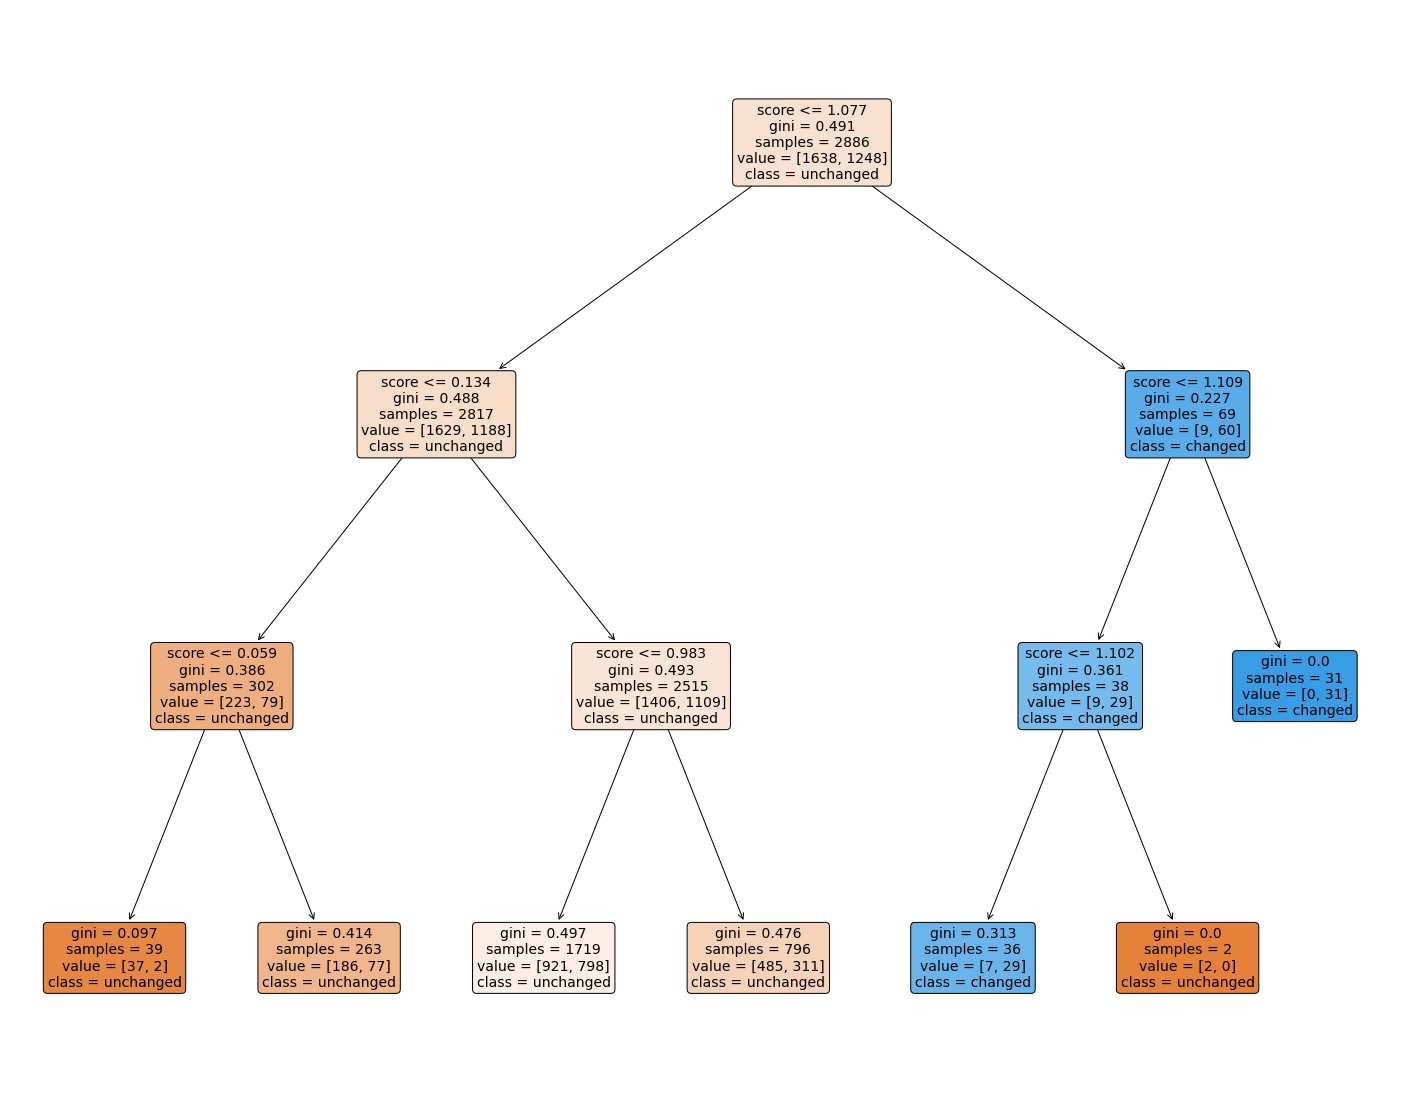

In [13]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, 
              feature_names=['task','metric','score'],
              class_names=['unchanged','changed'],
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.show()

In [14]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_2 <= 1.08
|   |--- feature_2 <= 0.13
|   |   |--- feature_2 <= 0.06
|   |   |   |--- class: 0.0
|   |   |--- feature_2 >  0.06
|   |   |   |--- class: 0.0
|   |--- feature_2 >  0.13
|   |   |--- feature_2 <= 0.98
|   |   |   |--- class: 0.0
|   |   |--- feature_2 >  0.98
|   |   |   |--- class: 0.0
|--- feature_2 >  1.08
|   |--- feature_2 <= 1.11
|   |   |--- feature_2 <= 1.10
|   |   |   |--- class: 1.0
|   |   |--- feature_2 >  1.10
|   |   |   |--- class: 0.0
|   |--- feature_2 >  1.11
|   |   |--- class: 1.0



In [ ]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(clf, feature, gold,
                target_name="target",
                feature_names=['task','metric','score'],
                class_names=['not changed','changed'])

viz

d:\python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [27]:
token_dict= {'attack': {}, 'bag': {}, 'ball': {}, 'bit': {}, 'chairman': {}, 'circle': {}, 'contemplation': {}, 'donkey': {}, 'edge': {}, 'face': {}, 'fiction': {}, 'gas': {}, 'graft': {}, 'head': {}, 'land': {}, 'lane': {}, 'lass': {}, 'multitude': {}, 'ounce': {}, 'part': {}, 'pin': {}, 'plane': {}, 'player': {}, 'prop': {}, 'quilt': {}, 'rag': {}, 'record': {}, 'relationship': {}, 'risk': {}, 'savage': {}, 'stab': {}, 'stroke': {}, 'thump': {}, 'tip': {}, 'tree': {}, 'twist': {}, 'word': {}}

In [28]:
token_list = list(token_dict.keys())
len(token_list)
new_dict = {item:defaultdict(dict) for item in token_list}

In [52]:
def read(path,filename,metric):
    result=[]
    with open(path,'r') as f:
        dict_ = {}
        for line in f:
            token, score = line.split('\t')
            field = "_".join([filename,metric])
            new_dict[token][field]=float(score[:-1])
            dict_[token]=float(score[:-1])
        dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda item: item[1], reverse=True)}
        result = [{'task':filename, 'metric':metric, 'token':k, 'score':v, 'rank':i} for i, (k,v) in enumerate(dict_.items())]
        
    return result

results=[]
metrics = ['cosine','distance','jsd']
for metric in metrics:
    for filename in os.listdir(f"results/{metric}"):
        if filename!='discovery_noun' and filename!='discovery_verb' and filename!='gold.txt': 
            print(filename)
            path = os.path.join(f"results/{metric}", filename)
            results += read(path, filename,metric)

        
        


average.txt
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
majority_vote_ave.txt
majority_vote_max.txt
majority_vote_min.txt
max.txt
min.txt
ner
nli
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
sst2
sst2_local_finetune
sst_hously
sst_pfeiffer
textual_sim
average.txt
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
majority_vote_ave.txt
majority_vote_max.txt
majority_vote_min.txt
max.txt
min.txt
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim
average.txt
bert_base
error_detect
histbert
histbert-10
histbert-5
histbert-full
ling_accept
majority_vote_ave.txt
majority_vote_max.txt
majority_vote_min.txt
max.txt
min.txt
ner
phrase_chunk
pos
pos_local_finetune
read_compre
sem_tag
snli
sst2
sst2_hously
sst2_local_finetune
sst2_pfeiffer
textual_sim


In [53]:
for k,v in gold_info_dis.items():
    new_dict[k]['gold']=v

In [54]:
reformat=[]
for k,v in new_dict.items():
    tmp_dict={}
    tmp_dict['token']=k
    for k_,v_ in v.items():
        tmp_dict[k_]=v_
    reformat.append(tmp_dict)

In [55]:
reformat[0]

{'token': 'attack',
 'average.txt_cosine': 0.9809183887558841,
 'bert_base_cosine': 1.0425012341045907,
 'error_detect_cosine': 1.0214023462155886,
 'gold.txt_cosine': 0.1439699927,
 'histbert_cosine': 1.0447367973405945,
 'histbert-10_cosine': 1.028016127228024,
 'histbert-5_cosine': 1.0222454160157206,
 'histbert-full_cosine': 1.0406636828420461,
 'ling_accept_cosine': 1.0386170270687267,
 'majority_vote_ave.txt_cosine': 1.0413620129319785,
 'majority_vote_max.txt_cosine': 1.0447367973405945,
 'majority_vote_min.txt_cosine': 1.0356139640851365,
 'max.txt_cosine': 1.0447367973405945,
 'min.txt_cosine': 0.1439699927,
 'ner_cosine': 1.0034389203481144,
 'nli_cosine': 1.0114952135209119,
 'phrase_chunk_cosine': 1.0056661775112556,
 'pos_cosine': 1.0055095956687823,
 'pos_local_finetune_cosine': 1.0016587372105394,
 'read_compre_cosine': 1.0390138572517182,
 'sem_tag_cosine': 1.0072916216312047,
 'sst2_cosine': 1.0425960561975918,
 'sst2_local_finetune_cosine': 1.0010579798392778,
 'sst_h

In [56]:
import csv
keys = reformat[0].keys()

with open('dt_new.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(reformat)

In [57]:
import pandas as pd
df = pd.read_csv('dt_new.csv')
df

,token,average.txt_cosine,bert_base_cosine,error_detect_cosine,gold.txt_cosine,histbert_cosine,histbert-10_cosine,histbert-5_cosine,histbert-full_cosine,ling_accept_cosine,...,pos_local_finetune_jsd,read_compre_jsd,sem_tag_jsd,snli_jsd,sst2_jsd,sst2_hously_jsd,sst2_local_finetune_jsd,sst2_pfeiffer_jsd,textual_sim_jsd,gold
0,attack,0.980918,1.042501,1.021402,0.143970,1.044737,1.028016,1.022245,1.040664,1.038617,...,0.231197,0.274574,0.155111,0.210221,0.272501,0.194594,0.129576,0.238557,0.227378,1.0
1,bag,0.973190,1.025795,1.020604,0.100364,1.032862,1.021425,1.018548,1.028869,1.028326,...,0.181588,0.247224,0.167169,0.168343,0.168758,0.219424,0.084116,0.181305,0.309829,0.0
2,ball,1.000793,1.054072,1.031469,0.409367,1.074492,1.039515,1.036283,1.027298,1.058767,...,0.198234,0.291136,0.228827,0.259024,0.267298,0.286806,0.181425,0.272985,0.240498,0.0
3,bit,1.005657,1.060314,1.035746,0.306577,1.068328,1.065599,1.063340,1.047953,1.075342,...,0.165941,0.297059,0.245826,0.238083,0.209439,0.351057,0.224573,0.244387,0.259612,1.0
4,chairman,0.994124,1.071409,1.035238,0.000000,1.085985,1.063637,1.067170,1.066416,1.070121,...,0.222134,0.355852,0.236208,0.397764,0.350793,0.397764,0.424424,0.335377,0.335945,0.0
5,circle,0.980805,1.026371,1.026864,0.171087,1.030393,1.025756,1.021694,1.037424,1.027430,...,0.126667,0.244985,0.205302,0.132858,0.138033,0.148166,0.136272,0.124728,0.175605,1.0
6,contemplation,0.977019,1.020653,1.028166,0.070839,1.033177,1.050179,1.067926,1.064424,1.018366,...,0.125151,0.133159,0.072527,0.079833,0.164476,0.066802,0.082781,0.072401,0.167283,0.0
7,donkey,0.966386,1.009740,1.007844,0.160104,1.010538,1.014828,1.016432,1.016191,1.010707,...,0.109131,0.141181,0.094964,0.105641,0.066430,0.077374,0.096294,0.053618,0.075532,0.0
8,edge,0.983198,1.028140,1.016946,0.260966,1.025101,1.024010,1.024145,1.035330,1.030440,...,0.212208,0.208155,0.207940,0.156486,0.170023,0.165808,0.104774,0.148412,0.204812,1.0
9,face,0.971482,1.015653,1.011769,0.137791,1.017212,1.014783,1.014342,1.022641,1.020344,...,0.359481,0.121738,0.097234,0.149592,0.138351,0.127071,0.084773,0.133762,0.152695,0.0


In [58]:
target = list(df.columns)
target.remove("token")
target.remove("gold")
df1 = df[target]
features = df1.to_numpy()
features

array([[0.98091839, 1.04250123, 1.02140235, ..., 0.12957602, 0.23855722,
        0.22737829],
       [0.97318954, 1.02579461, 1.02060416, ..., 0.08411558, 0.18130458,
        0.30982912],
       [1.00079295, 1.05407234, 1.03146946, ..., 0.18142475, 0.27298536,
        0.24049783],
       ...,
       [0.96615604, 1.01589266, 1.01021126, ..., 0.10308139, 0.18022674,
        0.24352739],
       [0.99256274, 1.03532812, 1.02297768, ..., 0.07810045, 0.21822816,
        0.27741446],
       [0.97350522, 1.01816869, 1.01399135, ..., 0.08480361, 0.1224285 ,
        0.12848454]])

In [59]:
gold = df['gold'].values

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
clf = tree.DecisionTreeClassifier()
clf = clf.fit(features, gold)

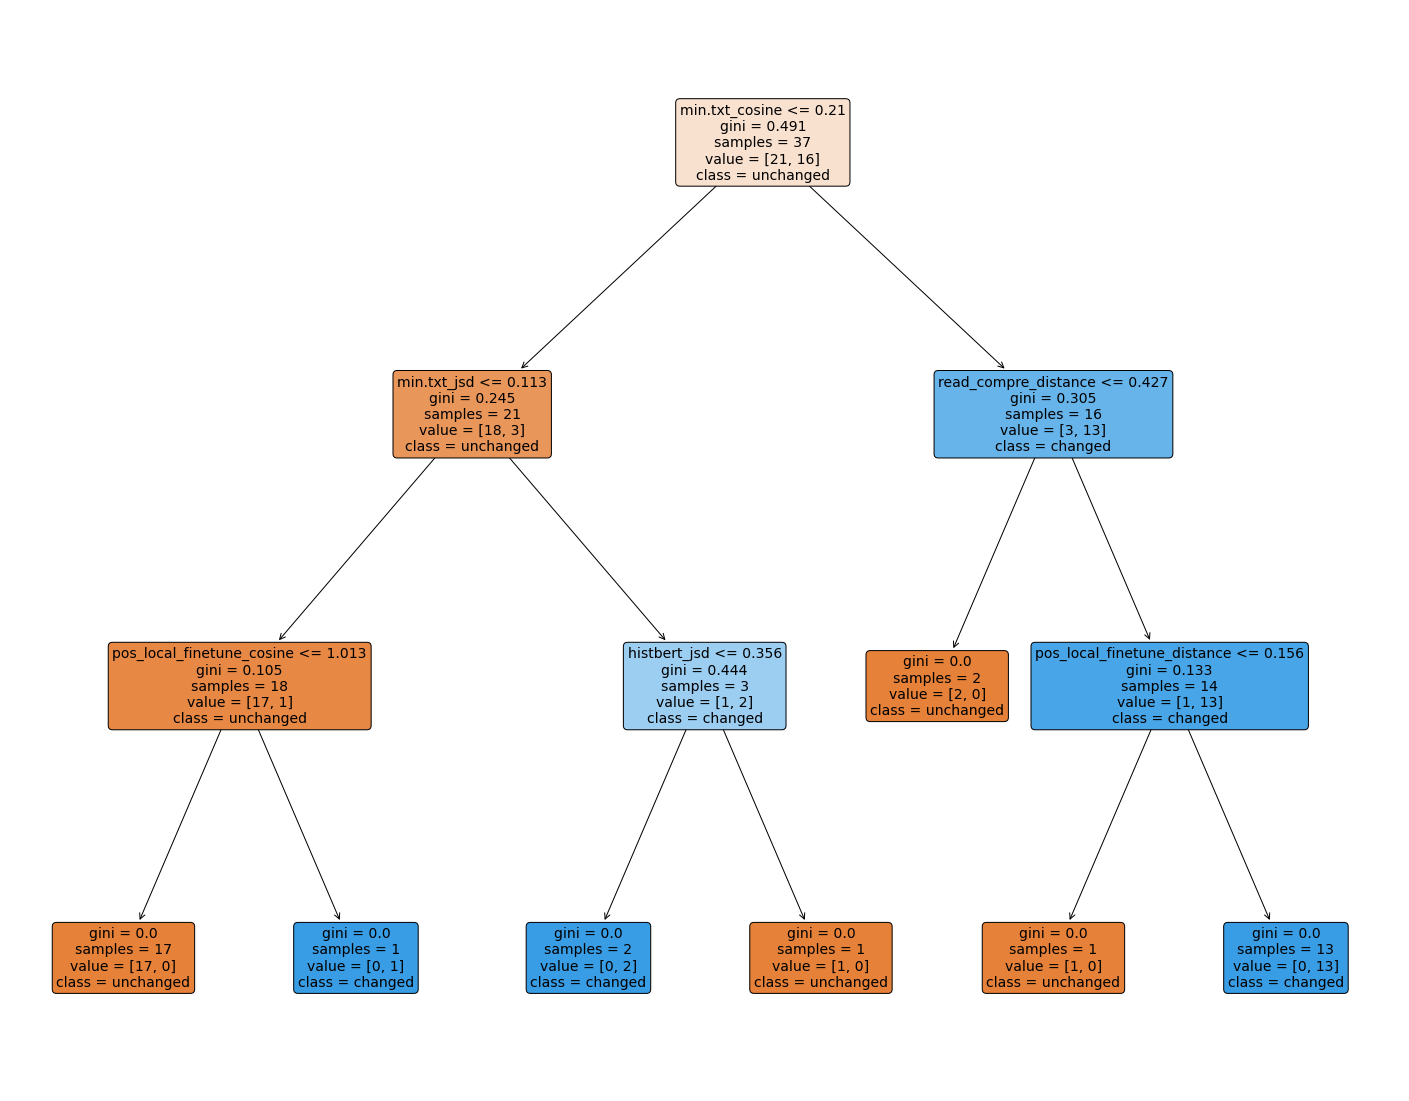

In [61]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, 
              feature_names=target,
              class_names=['unchanged','changed'],
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.show()

# MISC

In [64]:
single_case = df_cosine[(df_cosine['task']=='gold.txt')|(df_cosine['task']=='pos')]

In [62]:
single_case

,task,metric,token,score
2410,gold.txt,distance,attack,0.143970
2411,gold.txt,distance,bag,0.100364
2412,gold.txt,distance,ball,0.409367
2413,gold.txt,distance,bit,0.306577
2414,gold.txt,distance,chairman,0.000000
...,...,...,...,...
2664,ner,distance,stab,1.003967
2665,ner,distance,twist,1.003516
2666,ner,distance,attack,1.003439
2667,ner,distance,gas,1.010593


In [48]:
decrease={}
with open('results/cosine/gold.txt','r') as f:
    for line in f:
        token, score = line.split('\t')
        decrease[token]=float(score[:-1])
increase = {k: v for k, v in sorted(decrease.items(), key=lambda item: item[1])}        
print(increase)
increase_list = list(increase.keys())
print(increase_list)

{'chairman': 0.0, 'risk': 0.0, 'fiction': 0.0207232682, 'relationship': 0.0562177896, 'contemplation': 0.070838721, 'tree': 0.070838721, 'savage': 0.0968689424, 'bag': 0.1003636619, 'multitude': 0.1003636619, 'lane': 0.1037200629, 'quilt': 0.1231453661, 'face': 0.137791275, 'thump': 0.1429915711, 'attack': 0.1439699927, 'gas': 0.1595695865, 'donkey': 0.1601038896, 'part': 0.161270809, 'circle': 0.1710871199, 'stroke': 0.1762311532, 'word': 0.1793071623, 'pin': 0.2072118595, 'lass': 0.2125896937, 'land': 0.2234476353, 'edge': 0.2609655868, 'player': 0.2736674651, 'rag': 0.2765152931, 'ounce': 0.2848990681, 'head': 0.2952561247, 'bit': 0.3065766263, 'twist': 0.3984926634, 'stab': 0.4005896829, 'ball': 0.4093665525, 'record': 0.4273504707, 'graft': 0.5539755971, 'prop': 0.624759971, 'tip': 0.6788987615, 'plane': 0.8823475834}
['chairman', 'risk', 'fiction', 'relationship', 'contemplation', 'tree', 'savage', 'bag', 'multitude', 'lane', 'quilt', 'face', 'thump', 'attack', 'gas', 'donkey', '

[Text(0, 0, 'chairman'),
 Text(0, 0, 'risk'),
 Text(0, 0, 'fiction'),
 Text(0, 0, 'relationship'),
 Text(0, 0, 'contemplation'),
 Text(0, 0, 'tree'),
 Text(0, 0, 'savage'),
 Text(0, 0, 'bag'),
 Text(0, 0, 'multitude'),
 Text(0, 0, 'lane'),
 Text(0, 0, 'quilt'),
 Text(0, 0, 'face'),
 Text(0, 0, 'thump'),
 Text(0, 0, 'attack'),
 Text(0, 0, 'gas'),
 Text(0, 0, 'donkey'),
 Text(0, 0, 'part'),
 Text(0, 0, 'circle'),
 Text(0, 0, 'stroke'),
 Text(0, 0, 'word'),
 Text(0, 0, 'pin'),
 Text(0, 0, 'lass'),
 Text(0, 0, 'land'),
 Text(0, 0, 'edge'),
 Text(0, 0, 'player'),
 Text(0, 0, 'rag'),
 Text(0, 0, 'ounce'),
 Text(0, 0, 'head'),
 Text(0, 0, 'bit'),
 Text(0, 0, 'twist'),
 Text(0, 0, 'stab'),
 Text(0, 0, 'ball'),
 Text(0, 0, 'record'),
 Text(0, 0, 'graft'),
 Text(0, 0, 'prop'),
 Text(0, 0, 'tip'),
 Text(0, 0, 'plane')]

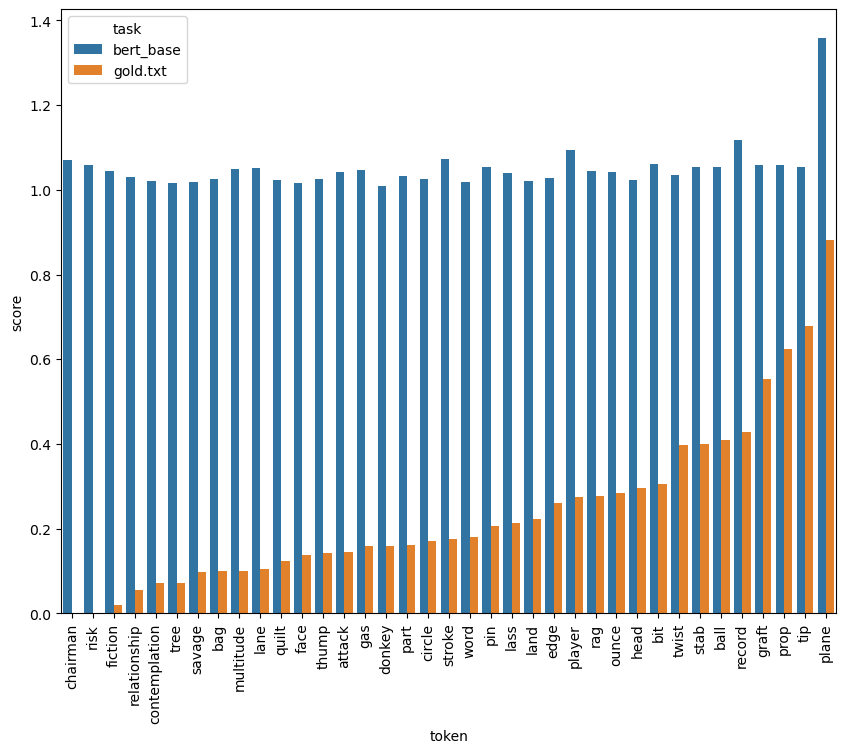

In [49]:
import seaborn as sns
from matplotlib.pyplot import figure
order_list = ['first', 'second', 'third']
figure(figsize=(10,8), dpi=100)
res = sns.barplot(data=single_case, x='token',y='score',hue='task',order=increase_list)
res.set_xticklabels(res.get_xticklabels(), rotation=90)

[Text(0, 0, 'chairman'),
 Text(0, 0, 'risk'),
 Text(0, 0, 'fiction'),
 Text(0, 0, 'relationship'),
 Text(0, 0, 'contemplation'),
 Text(0, 0, 'tree'),
 Text(0, 0, 'savage'),
 Text(0, 0, 'bag'),
 Text(0, 0, 'multitude'),
 Text(0, 0, 'lane'),
 Text(0, 0, 'quilt'),
 Text(0, 0, 'face'),
 Text(0, 0, 'thump'),
 Text(0, 0, 'attack'),
 Text(0, 0, 'gas'),
 Text(0, 0, 'donkey'),
 Text(0, 0, 'part'),
 Text(0, 0, 'circle'),
 Text(0, 0, 'stroke'),
 Text(0, 0, 'word'),
 Text(0, 0, 'pin'),
 Text(0, 0, 'lass'),
 Text(0, 0, 'land'),
 Text(0, 0, 'edge'),
 Text(0, 0, 'player'),
 Text(0, 0, 'rag'),
 Text(0, 0, 'ounce'),
 Text(0, 0, 'head'),
 Text(0, 0, 'bit'),
 Text(0, 0, 'twist'),
 Text(0, 0, 'stab'),
 Text(0, 0, 'ball'),
 Text(0, 0, 'record'),
 Text(0, 0, 'graft'),
 Text(0, 0, 'prop'),
 Text(0, 0, 'tip'),
 Text(0, 0, 'plane')]

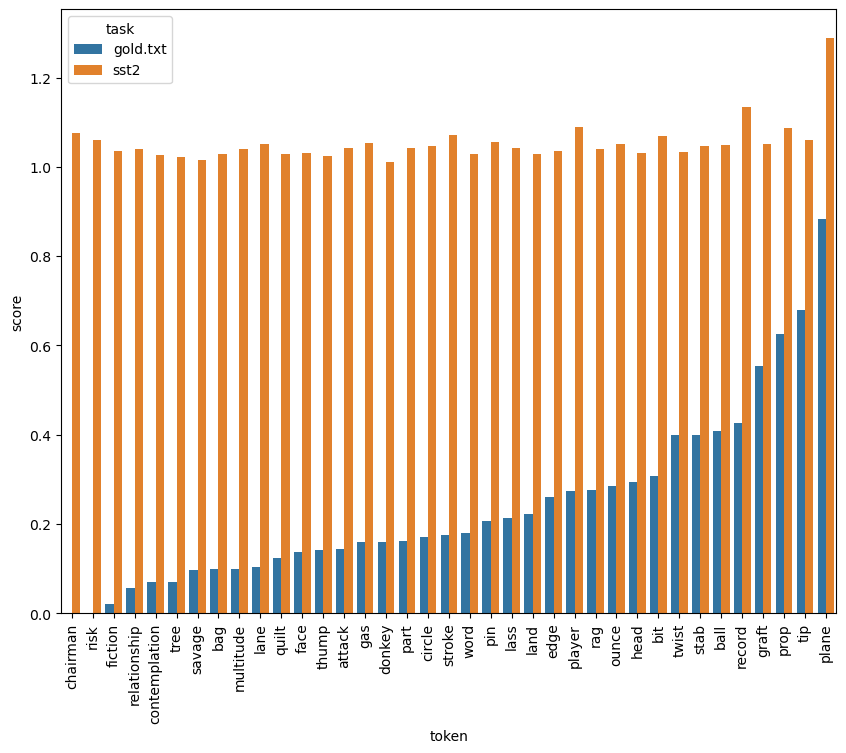

In [57]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(10,8), dpi=100)
res = sns.barplot(data=single_case, x='token',y='score',hue='task',order=increase_list)
res.set_xticklabels(res.get_xticklabels(), rotation=90)

[Text(0, 0, 'chairman'),
 Text(0, 0, 'risk'),
 Text(0, 0, 'fiction'),
 Text(0, 0, 'relationship'),
 Text(0, 0, 'contemplation'),
 Text(0, 0, 'tree'),
 Text(0, 0, 'savage'),
 Text(0, 0, 'bag'),
 Text(0, 0, 'multitude'),
 Text(0, 0, 'lane'),
 Text(0, 0, 'quilt'),
 Text(0, 0, 'face'),
 Text(0, 0, 'thump'),
 Text(0, 0, 'attack'),
 Text(0, 0, 'gas'),
 Text(0, 0, 'donkey'),
 Text(0, 0, 'part'),
 Text(0, 0, 'circle'),
 Text(0, 0, 'stroke'),
 Text(0, 0, 'word'),
 Text(0, 0, 'pin'),
 Text(0, 0, 'lass'),
 Text(0, 0, 'land'),
 Text(0, 0, 'edge'),
 Text(0, 0, 'player'),
 Text(0, 0, 'rag'),
 Text(0, 0, 'ounce'),
 Text(0, 0, 'head'),
 Text(0, 0, 'bit'),
 Text(0, 0, 'twist'),
 Text(0, 0, 'stab'),
 Text(0, 0, 'ball'),
 Text(0, 0, 'record'),
 Text(0, 0, 'graft'),
 Text(0, 0, 'prop'),
 Text(0, 0, 'tip'),
 Text(0, 0, 'plane')]

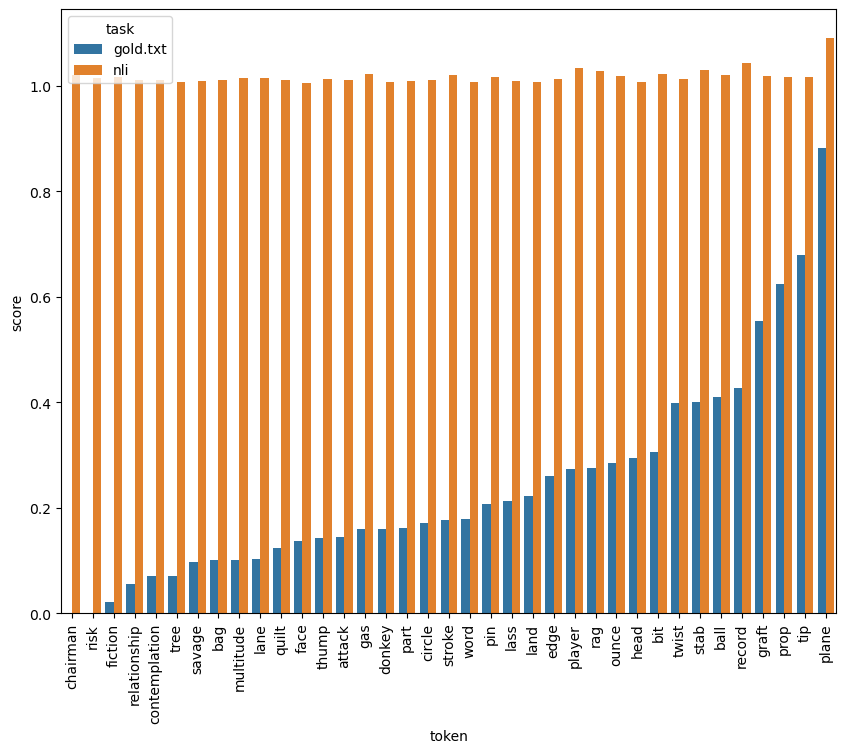

In [60]:
import seaborn as sns
from matplotlib.pyplot import figure
order_list = ['first', 'second', 'third']
figure(figsize=(10,8), dpi=100)
res = sns.barplot(data=single_case, x='token',y='score',hue='task',order=increase_list)
res.set_xticklabels(res.get_xticklabels(), rotation=90)

[Text(0, 0, 'chairman'),
 Text(0, 0, 'risk'),
 Text(0, 0, 'fiction'),
 Text(0, 0, 'relationship'),
 Text(0, 0, 'contemplation'),
 Text(0, 0, 'tree'),
 Text(0, 0, 'savage'),
 Text(0, 0, 'bag'),
 Text(0, 0, 'multitude'),
 Text(0, 0, 'lane'),
 Text(0, 0, 'quilt'),
 Text(0, 0, 'face'),
 Text(0, 0, 'thump'),
 Text(0, 0, 'attack'),
 Text(0, 0, 'gas'),
 Text(0, 0, 'donkey'),
 Text(0, 0, 'part'),
 Text(0, 0, 'circle'),
 Text(0, 0, 'stroke'),
 Text(0, 0, 'word'),
 Text(0, 0, 'pin'),
 Text(0, 0, 'lass'),
 Text(0, 0, 'land'),
 Text(0, 0, 'edge'),
 Text(0, 0, 'player'),
 Text(0, 0, 'rag'),
 Text(0, 0, 'ounce'),
 Text(0, 0, 'head'),
 Text(0, 0, 'bit'),
 Text(0, 0, 'twist'),
 Text(0, 0, 'stab'),
 Text(0, 0, 'ball'),
 Text(0, 0, 'record'),
 Text(0, 0, 'graft'),
 Text(0, 0, 'prop'),
 Text(0, 0, 'tip'),
 Text(0, 0, 'plane')]

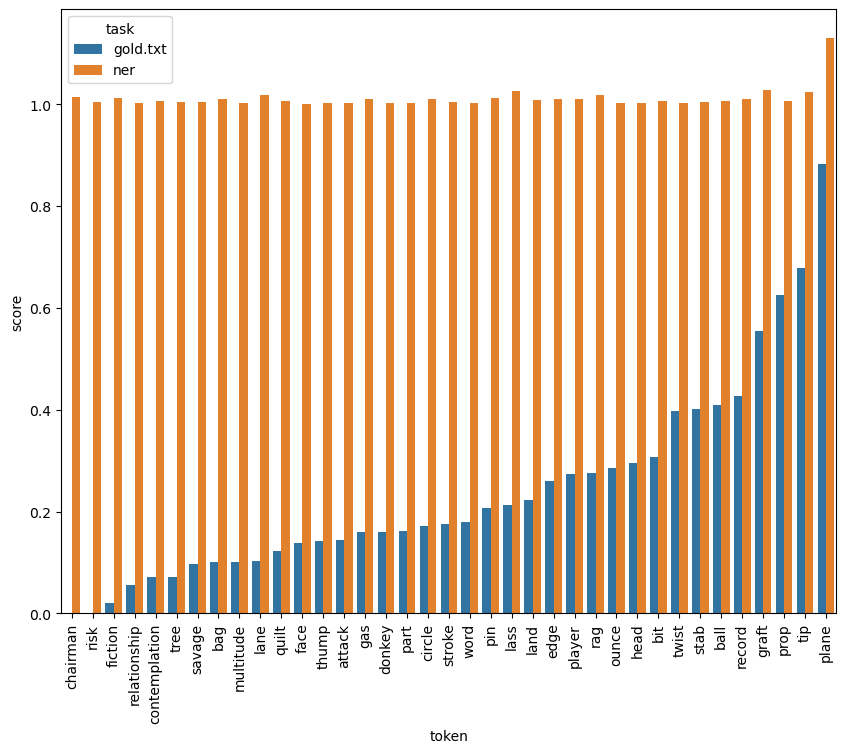

In [63]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(10,8), dpi=100)
res = sns.barplot(data=single_case, x='token',y='score',hue='task',order=increase_list)
res.set_xticklabels(res.get_xticklabels(), rotation=90)

[Text(0, 0, 'chairman'),
 Text(0, 0, 'risk'),
 Text(0, 0, 'fiction'),
 Text(0, 0, 'relationship'),
 Text(0, 0, 'contemplation'),
 Text(0, 0, 'tree'),
 Text(0, 0, 'savage'),
 Text(0, 0, 'bag'),
 Text(0, 0, 'multitude'),
 Text(0, 0, 'lane'),
 Text(0, 0, 'quilt'),
 Text(0, 0, 'face'),
 Text(0, 0, 'thump'),
 Text(0, 0, 'attack'),
 Text(0, 0, 'gas'),
 Text(0, 0, 'donkey'),
 Text(0, 0, 'part'),
 Text(0, 0, 'circle'),
 Text(0, 0, 'stroke'),
 Text(0, 0, 'word'),
 Text(0, 0, 'pin'),
 Text(0, 0, 'lass'),
 Text(0, 0, 'land'),
 Text(0, 0, 'edge'),
 Text(0, 0, 'player'),
 Text(0, 0, 'rag'),
 Text(0, 0, 'ounce'),
 Text(0, 0, 'head'),
 Text(0, 0, 'bit'),
 Text(0, 0, 'twist'),
 Text(0, 0, 'stab'),
 Text(0, 0, 'ball'),
 Text(0, 0, 'record'),
 Text(0, 0, 'graft'),
 Text(0, 0, 'prop'),
 Text(0, 0, 'tip'),
 Text(0, 0, 'plane')]

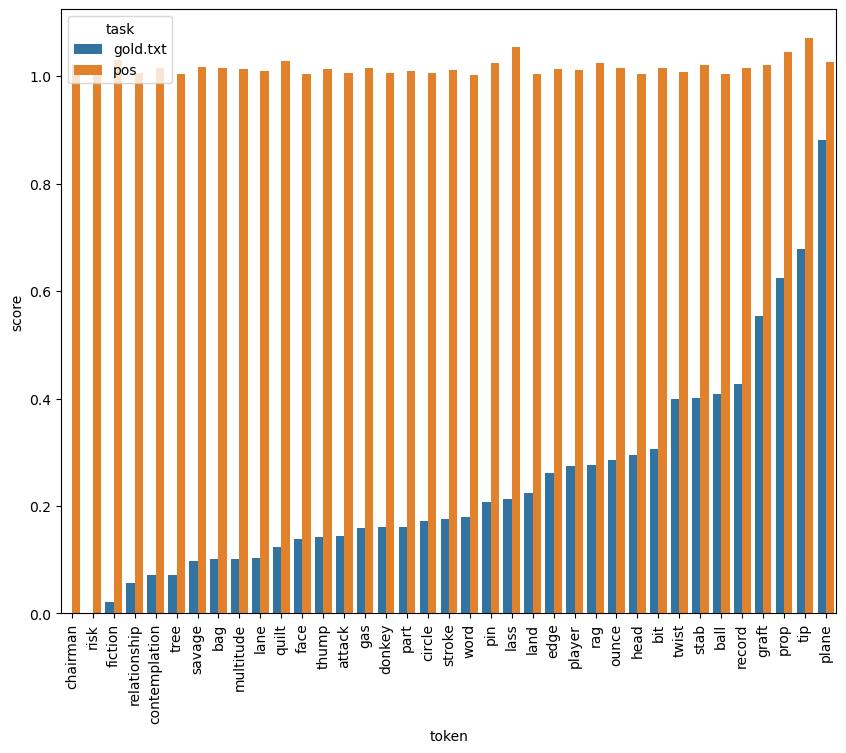

In [65]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(10,8), dpi=100)
res = sns.barplot(data=single_case, x='token',y='score',hue='task',order=increase_list)
res.set_xticklabels(res.get_xticklabels(), rotation=90)

In [1]:
# averaging 
import pandas as pd
import json
with open("all_results.json","r") as f:
    a= json.load(f)
f= pd.DataFrame(a)
f['score']=f['score'].astype(float)

In [2]:
f

,task,metric,token,score
0,bert_base,cosine,tip,1.054088
1,bert_base,cosine,attack,1.042501
2,bert_base,cosine,stab,1.053895
3,bert_base,cosine,head,1.023131
4,bert_base,cosine,bag,1.025795
...,...,...,...,...
4609,textual_sim,jsd,twist,1.023222
4610,textual_sim,jsd,bag,1.022544
4611,textual_sim,jsd,lane,1.037719
4612,textual_sim,jsd,contemplation,1.014444


In [3]:
cos=f[f["metric"]=="cosine"]
print(cos.groupby(["token"]).mean())

              score
token              
Let        1.083643
according  1.138041
account    1.063091
act        1.040799
action     1.048295
...             ...
written    1.016597
wrote      1.041279
year       1.059367
years      1.021545
youth      1.035732

[812 rows x 1 columns]
